# TinyHiera with multiloader

In [4]:
for k, v in train_dl.loaders.items():
    pass

NameError: name 'train_dl' is not defined

In [3]:
np.unique(train_dl.loaders['29513-3-5'].dataset.meta_conditions["tier"])

NameError: name 'np' is not defined

In [81]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=16
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [113]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths[4:5], cfg)

In [114]:
targets, predictions = [],[]
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
        targets.append(responses.to(torch.float32).cpu().numpy())

49it [00:10,  4.86it/s]


In [115]:
r1 = np.vstack(np.vstack(predictions))

In [116]:
r2 = np.vstack(np.vstack(targets))

In [117]:
cs = []
for n in range(5000):
    c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
    cs.append(c)

In [118]:
np.stack(cs).mean()

np.float64(0.08141439593603779)

In [53]:
responses.shape

torch.Size([32, 16, 7671])

In [56]:
from numpy.typing import ArrayLike
from typing import Tuple, Union
def corr(
    y1: ArrayLike, y2: ArrayLike, axis: Union[None, int, Tuple[int]] = -1, eps: int = 1e-8, **kwargs
) -> np.ndarray:
    """
    Compute the correlation between two NumPy arrays along the specified dimension(s).

    Args:
        y1:      first NumPy array
        y2:      second NumPy array
        axis:    dimension(s) along which the correlation is computed. Any valid NumPy axis spec works here
        eps:     offset to the standard deviation to avoid exploding the correlation due to small division (default 1e-8)
        **kwargs: passed to final numpy.mean operation over standardized y1 * y2

    Returns: correlation array for the neurons
    """

    y1 = (y1 - y1.mean(axis=axis, keepdims=True)) / (y1.std(axis=axis, keepdims=True, ddof=0) + eps)
    y2 = (y2 - y2.mean(axis=axis, keepdims=True)) / (y2.std(axis=axis, keepdims=True, ddof=0) + eps)
    return (y1 * y2).mean(axis=axis, **kwargs)

In [1]:
plt.imshow(videos.to(torch.float32).cpu().numpy()[0,0,0])

NameError: name 'plt' is not defined

In [42]:
32*8*16 / 8

512.0

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader


In [3]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

## Load Config Object from .yaml file

### Modify the config

In [4]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [5]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

Process Process-37:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 374, in _worker_loop
    if done_event.is_set():
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 327, in is_set
    def is_set(self):
KeyboardInterrupt


# Hiera

In [6]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,144, 256),
                     num_heads=1, 
                     stages=(4, 4, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(2, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(4, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[1][2]
features.shape

torch.Size([8, 4, 18, 32, 384])

In [8]:
4*18*32

2304

In [9]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = tiny_hiera(example_in, return_intermediates=True);

100% 100/100 [00:01<00:00, 78.77it/s]


In [10]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos, return_intermediates=True);
        if i > 200:
            break

201it [00:13, 14.63it/s]


In [18]:
32*15*16

7680

In [7]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [8]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [20]:
class MouseHiera(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 dim=384,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wo = nn.Linear(dim_head * num_heads, dim, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 16, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.wo(o)
        o = o.view(b, -1,n, d)
        w = r.readout[key].weight
        o = torch.einsum("btni, njr->bnt", o, w, )
        o = o + r.readout[key].bias
        return self.activation(o)

In [21]:
r = MouseHiera(tiny_hiera, train_dl)
#opt_r = torch.compile(r, )
opt_r = r

In [22]:
torch.set_float32_matmul_precision('medium')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = torch.compile(r).cuda().to(torch.bfloat16)


In [23]:
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(opt_r.parameters(), lr=3e-4, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [24]:
losses, corrs, lrs = [], [], []
for train_loop in range(10):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:23, 23.68s/it]

0.007343916326919166


8it [02:42, 19.99s/it]W1015 22:38:04.939000 49417 torch/_dynamo/convert_frame.py:844] [3/8] torch._dynamo hit config.cache_size_limit (8)
W1015 22:38:04.939000 49417 torch/_dynamo/convert_frame.py:844] [3/8]    function: 'forward' (/tmp/ipykernel_49417/1076961244.py:21)
W1015 22:38:04.939000 49417 torch/_dynamo/convert_frame.py:844] [3/8]    last reason: 3/0: L['key'] == '29513-3-5'                                     
W1015 22:38:04.939000 49417 torch/_dynamo/convert_frame.py:844] [3/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 22:38:04.939000 49417 torch/_dynamo/convert_frame.py:844] [3/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
101it [03:05,  3.72it/s]

-0.001170995330793795


201it [03:30,  3.70it/s]

-0.0005972377717927766


301it [03:54,  3.75it/s]

0.002170090139526828


401it [04:19,  3.75it/s]

0.0018103329813956512


501it [04:44,  3.74it/s]

9.067469304960049e-05


601it [05:08,  3.67it/s]

0.00028628186892138373


701it [05:33,  3.73it/s]

0.0009684837899271466


801it [05:58,  3.71it/s]

0.0030532474238735554


901it [06:23,  3.75it/s]

0.014970696499761129


1001it [06:47,  3.73it/s]

0.02898700034841999


1101it [07:12,  3.75it/s]

0.05101814557149333


1201it [07:37,  3.68it/s]

0.05527010444553504


1301it [08:02,  3.71it/s]

0.08669648775318459


1401it [08:27,  3.69it/s]

0.10566828475014133


1501it [08:51,  3.75it/s]

0.12202294313916742


1601it [09:16,  3.70it/s]

0.11405319590940582


1701it [09:41,  3.70it/s]

0.11965108680344386


1801it [10:06,  3.73it/s]

0.12465358298717955


1901it [10:31,  3.73it/s]

0.13633170918839424


2001it [10:56,  3.75it/s]

0.12299826078258197


2020it [11:00,  3.06it/s]
1it [00:00,  3.08it/s]

0.12790364081569397


101it [00:25,  3.76it/s]

0.12765698096836822


201it [00:49,  3.74it/s]

0.125390889871816


301it [01:14,  3.76it/s]

0.12196851679921036


401it [01:39,  3.75it/s]

0.11955712437749373


501it [02:04,  3.74it/s]

0.12399368318661573


601it [02:29,  3.69it/s]

0.11864381364999096


701it [02:53,  3.75it/s]

0.12736556064401294


801it [03:18,  3.73it/s]

0.12255108945083189


901it [03:43,  3.70it/s]

0.12673104056407247


1001it [04:08,  3.75it/s]

0.13323873747240095


1101it [04:32,  3.73it/s]

0.13243969714152484


1201it [04:57,  3.76it/s]

0.12747262943619478


1301it [05:22,  3.76it/s]

0.12216554255108243


1401it [05:47,  3.72it/s]

0.12872131488113273


1501it [06:12,  3.76it/s]

0.13685233147136056


1601it [06:36,  3.70it/s]

0.1340601739938289


1701it [07:01,  3.73it/s]

0.12663720434539893


1801it [07:26,  3.76it/s]

0.12966704868826612


1901it [07:51,  3.75it/s]

0.13484360834725187


2001it [08:16,  3.74it/s]

0.13898215914108145


2020it [08:20,  4.03it/s]
1it [00:00,  3.07it/s]

0.13664159745919338


101it [00:25,  3.74it/s]

0.13335989141699794


201it [00:49,  3.76it/s]

0.1422614274081021


301it [01:14,  3.66it/s]

0.1310928396564675


401it [01:39,  3.74it/s]

0.14090075190580728


501it [02:04,  3.75it/s]

0.139164698743557


601it [02:29,  3.72it/s]

0.14017388557626476


701it [02:53,  3.72it/s]

0.13790884605692372


801it [03:18,  3.74it/s]

0.140165933570926


901it [03:43,  3.73it/s]

0.13407340070363333


1001it [04:08,  3.73it/s]

0.1346294358028614


1101it [04:33,  3.73it/s]

0.13735957890953526


1201it [04:57,  3.75it/s]

0.13697431242462788


1301it [05:22,  3.72it/s]

0.12993048153403033


1401it [05:47,  3.77it/s]

0.14331667013498348


1501it [06:12,  3.74it/s]

0.14857165555711874


1601it [06:37,  3.72it/s]

0.15556520896637513


1701it [07:02,  3.76it/s]

0.13675063985095723


1801it [07:26,  3.70it/s]

0.13729659356831095


1901it [07:51,  3.71it/s]

0.15065725970807944


2001it [08:16,  3.74it/s]

0.14498975472465875


2020it [08:21,  4.03it/s]
1it [00:00,  3.09it/s]

0.14356669920648843


101it [00:25,  3.71it/s]

0.14780163177063854


201it [00:49,  3.69it/s]

0.13479134065506856


301it [01:14,  3.72it/s]

0.15150444558451806


401it [01:39,  3.73it/s]

0.14165090533912245


501it [02:04,  3.73it/s]

0.14251416027841896


601it [02:29,  3.69it/s]

0.13750271143234177


701it [02:54,  3.73it/s]

0.15584600834846765


801it [03:19,  3.71it/s]

0.13989886441147625


901it [03:43,  3.73it/s]

0.14152602684188942


1001it [04:08,  3.75it/s]

0.14702235517957365


1101it [04:33,  3.75it/s]

0.1426872514771641


1201it [04:58,  3.71it/s]

0.13655166675408056


1301it [05:23,  3.74it/s]

0.141198027673186


1401it [05:47,  3.74it/s]

0.14430055364565997


1501it [06:12,  3.73it/s]

0.13906957567368192


1601it [06:37,  3.76it/s]

0.15028567915612168


1701it [07:02,  3.71it/s]

0.14133858896426008


1801it [07:27,  3.73it/s]

0.14727960898648468


1901it [07:52,  3.77it/s]

0.14087171757730882


2001it [08:16,  3.75it/s]

0.1429540906213323


2020it [08:21,  4.03it/s]
1it [00:00,  3.18it/s]

0.14545946124041545


101it [00:25,  3.71it/s]

0.13692487983438797


201it [00:49,  3.73it/s]

0.13987662178338436


301it [01:14,  3.77it/s]

0.14371591292058145


401it [01:39,  3.75it/s]

0.1488096598457885


501it [02:04,  3.74it/s]

0.15029286859252936


601it [02:29,  3.76it/s]

0.13219937896170164


701it [02:53,  3.74it/s]

0.13266198263825563


801it [03:18,  3.72it/s]

0.1470146770605542


901it [03:43,  3.76it/s]

0.14994119907308456


1001it [04:08,  3.73it/s]

0.1539608146888047


1101it [04:33,  3.73it/s]

0.1433833317090732


1201it [04:58,  3.77it/s]

0.15110898158291697


1301it [05:22,  3.74it/s]

0.1479105453545097


1401it [05:47,  3.72it/s]

0.14156411314737816


1501it [06:12,  3.75it/s]

0.13722047024158596


1601it [06:37,  3.74it/s]

0.14628318789555694


1701it [07:02,  3.72it/s]

0.14350790368650743


1801it [07:26,  3.73it/s]

0.13550582318648388


1901it [07:51,  3.69it/s]

0.1514369937187618


2001it [08:16,  3.69it/s]

0.13461165540704675


2020it [08:21,  4.03it/s]
1it [00:00,  3.15it/s]

0.15087577510560168


101it [00:25,  3.72it/s]

0.14359703077351527


201it [00:49,  3.76it/s]

0.15187488374432048


301it [01:14,  3.75it/s]

0.15069670910108296


401it [01:39,  3.73it/s]

0.14635131509414415


501it [02:04,  3.76it/s]

0.13950156027666885


601it [02:29,  3.74it/s]

0.14512714523029896


701it [02:54,  3.67it/s]

0.149514111519253


801it [03:18,  3.74it/s]

0.15019641950668255


901it [03:43,  3.70it/s]

0.14548099944241613


1001it [04:08,  3.72it/s]

0.1533695521451813


1101it [04:33,  3.76it/s]

0.1396689325239411


1201it [04:58,  3.77it/s]

0.14938308557687552


1301it [05:23,  3.67it/s]

0.1485107721517382


1401it [05:48,  3.75it/s]

0.14549830230629734


1501it [06:12,  3.75it/s]

0.14996691169071397


1601it [06:37,  3.72it/s]

0.1444740798414672


1701it [07:02,  3.71it/s]

0.14870824131890786


1801it [07:27,  3.75it/s]

0.14744099644911188


1901it [07:52,  3.68it/s]

0.1392391440856965


2001it [08:17,  3.75it/s]

0.16662804822727065


2020it [08:21,  4.03it/s]
1it [00:00,  3.11it/s]

0.14454430422282452


101it [00:25,  3.71it/s]

0.15074853832242727


201it [00:49,  3.73it/s]

0.1347540178316679


301it [01:14,  3.74it/s]

0.1550601679492447


401it [01:39,  3.76it/s]

0.15746869067553199


501it [02:04,  3.73it/s]

0.15475666909242772


601it [02:29,  3.73it/s]

0.15974419368410459


701it [02:54,  3.76it/s]

0.15664889401030033


801it [03:18,  3.73it/s]

0.1501539054754904


901it [03:43,  3.73it/s]

0.13684702188686404


1001it [04:08,  3.76it/s]

0.15151669817144775


1101it [04:33,  3.75it/s]

0.16667588643592826


1201it [04:58,  3.71it/s]

0.1613891401286418


1301it [05:23,  3.75it/s]

0.15808489061065592


1401it [05:47,  3.74it/s]

0.15678613495642135


1501it [06:12,  3.71it/s]

0.16001091473083018


1601it [06:37,  3.76it/s]

0.15139053070090747


1701it [07:02,  3.75it/s]

0.14312101204658115


1801it [07:27,  3.71it/s]

0.1539832955617288


1901it [07:52,  3.72it/s]

0.15601036392632464


2001it [08:16,  3.74it/s]

0.1625578510505571


2020it [08:21,  4.03it/s]
1it [00:00,  3.15it/s]

0.16205575487897234


101it [00:25,  3.74it/s]

0.15555881505696487


201it [00:50,  3.67it/s]

0.1522425878697137


301it [01:14,  3.77it/s]

0.1568719311592303


401it [01:39,  3.75it/s]

0.1636914932168627


501it [02:04,  3.70it/s]

0.15534790330796577


601it [02:29,  3.69it/s]

0.16290010447149497


701it [02:54,  3.75it/s]

0.16183820051470832


801it [03:19,  3.72it/s]

0.15429408203583905


901it [03:43,  3.73it/s]

0.16031958604817356


1001it [04:08,  3.62it/s]

0.15488507678729996


1101it [04:33,  3.71it/s]

0.15394302319319464


1201it [04:58,  3.76it/s]

0.16313605037674947


1301it [05:23,  3.74it/s]

0.1491981717313475


1401it [05:48,  3.72it/s]

0.1579899041468823


1501it [06:13,  3.76it/s]

0.1652736835899077


1601it [06:38,  3.73it/s]

0.15745684760286466


1701it [07:02,  3.68it/s]

0.16220571061922465


1801it [07:27,  3.75it/s]

0.16343946317703625


1901it [07:52,  3.62it/s]

0.15806473455318024


2001it [08:17,  3.66it/s]

0.16479086654526232


2020it [08:22,  4.02it/s]
1it [00:00,  2.88it/s]

0.15187826904130816


101it [00:25,  3.73it/s]

0.1663455459995963


201it [00:50,  3.67it/s]

0.15455224776773974


301it [01:15,  3.65it/s]

0.17676018436466479


401it [01:40,  3.61it/s]

0.17097633743362645


501it [02:05,  3.75it/s]

0.1655157356503402


601it [02:29,  3.73it/s]

0.16305459431524788


701it [02:54,  3.71it/s]

0.16863036385716645


801it [03:19,  3.72it/s]

0.16481645543014214


901it [03:44,  3.75it/s]

0.16293966877052005


1001it [04:09,  3.72it/s]

0.1558191157948071


1101it [04:34,  3.76it/s]

0.1600732141498958


1201it [04:58,  3.76it/s]

0.17056296174788782


1301it [05:23,  3.73it/s]

0.16742029439056635


1401it [05:48,  3.76it/s]

0.17779739554230647


1501it [06:13,  3.69it/s]

0.16148437541960292


1601it [06:38,  3.69it/s]

0.16201021408142532


1701it [07:03,  3.67it/s]

0.17433603994523386


1801it [07:28,  3.73it/s]

0.16271052883421405


1901it [07:53,  3.71it/s]

0.15361493892438868


2001it [08:18,  3.69it/s]

0.17365479790794888


2020it [08:23,  4.02it/s]
1it [00:00,  3.14it/s]

0.16957404899491502


101it [00:25,  3.70it/s]

0.15094892865875387


201it [00:50,  3.72it/s]

0.16333379649282606


301it [01:14,  3.72it/s]

0.16401460856211494


401it [01:39,  3.69it/s]

0.1720280479445576


501it [02:04,  3.69it/s]

0.16931790588856893


601it [02:29,  3.76it/s]

0.16821605693343256


701it [02:54,  3.70it/s]

0.15974829317320477


801it [03:19,  3.68it/s]

0.1700116786681914


901it [03:44,  3.77it/s]

0.15878938198729178


1001it [04:08,  3.70it/s]

0.16483722865605782


1101it [04:33,  3.71it/s]

0.17536220154959758


1201it [04:58,  3.76it/s]

0.15818937761062668


1301it [05:23,  3.68it/s]

0.18061703658033423


1401it [05:48,  3.72it/s]

0.1611987684720534


1501it [06:13,  3.77it/s]

0.16085500117374002


1601it [06:38,  3.66it/s]

0.16069571656161333


1701it [07:02,  3.69it/s]

0.17640878922791095


1801it [07:27,  3.76it/s]

0.17159026191612803


1901it [07:52,  3.63it/s]

0.16665269490933546


2001it [08:17,  3.66it/s]

0.15746050060282646


2020it [08:22,  4.02it/s]


In [2]:
plt.plot(losses)

NameError: name 'plt' is not defined

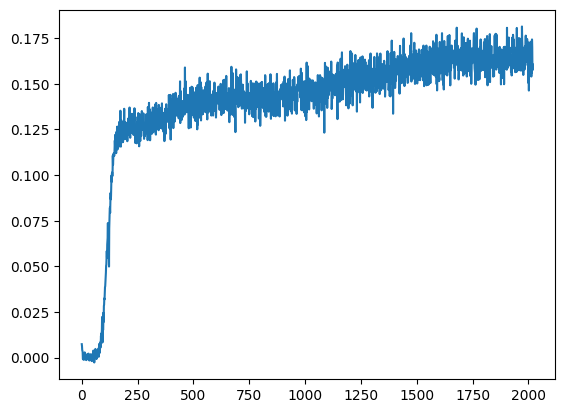

In [26]:
plt.plot(corrs)

In [29]:
losses, corrs = [], []
for _ in tqdm(range(500)):
    
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    with autocast("cuda", )
        out = opt_r.generate(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    losses.append(loss.item())
    neuron=0
    r2 = responses.to(torch.float32).cpu().numpy().flatten()
    r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
    corrs.append(np.corrcoef(r1,r2)[0,1].item())

  0% 0/500 [00:00<?, ?it/s]


RuntimeError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'

## Overfitting

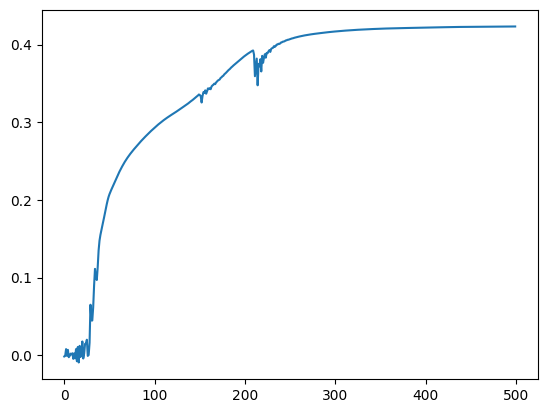

In [16]:
plt.plot(corrs)

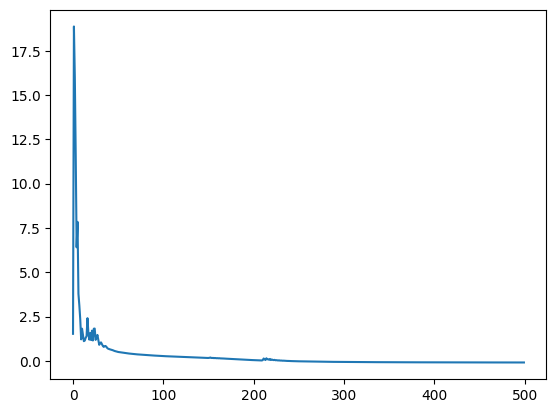

In [17]:
plt.plot(losses)

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [ ]:
opt.zero_grad()


In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

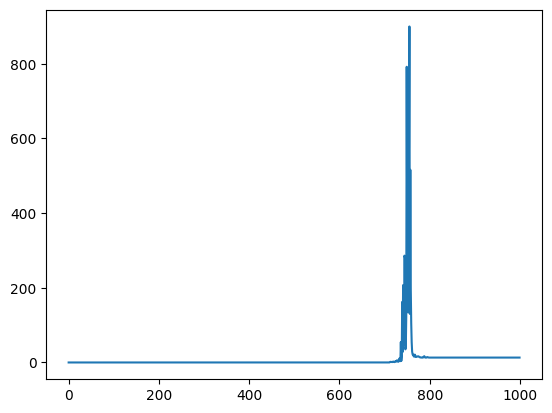

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


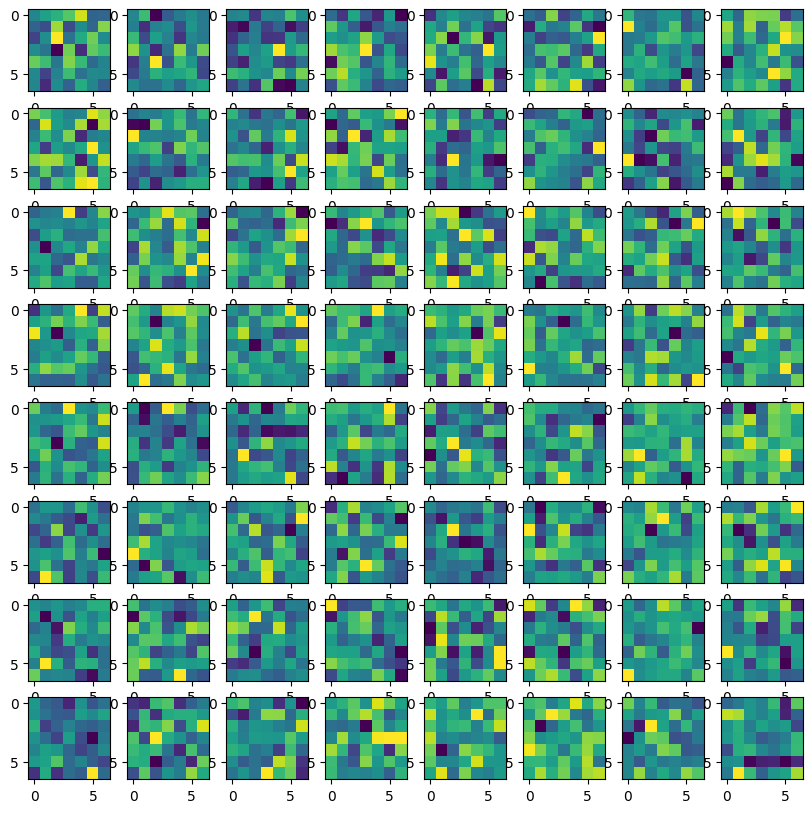

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))